In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import datasets, metrics
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor

In [4]:
df = pd.read_csv("../Data/Hourly consumption per cluster South Africa.csv")
df["time"] = df["time"].astype(str).str.zfill(3)
df.index = df["time"]
df["day"] = df["time"].str[:1]
df["hour"] = df["time"].str[1:]
df.drop(['time','Unnamed: 0'], axis = 1, inplace = True)


df.head()

,Cluster,consumption_kWh,CO2_intensity,day,hour
time,,,,,
000,0,57.697082,864.524537,0,00
001,0,55.224566,870.705770,0,01
002,0,54.344372,872.777702,0,02
003,0,54.252020,871.116731,0,03
004,0,63.636753,871.232315,0,04


,consumption_kWh,Morn-Ev,CO2_intensity
time,,,
000,407.010011,Morning,864.524537
001,384.379167,Morning,870.705770
002,376.351646,Morning,872.777702
003,404.229530,Morning,871.116731
004,558.483811,Morning,871.232315


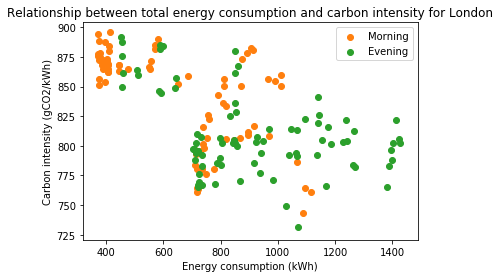

In [5]:
a = df.groupby('time')['consumption_kWh'].apply(lambda x: np.sum(x)).to_frame()

a['Morn-Ev'] = 'Morning'
a['Morn-Ev'] = a['Morn-Ev'].where(a.index.str[1:].astype(int) <12 , "Evening")


z = df.iloc[range(0,168),-3]
a["CO2_intensity"] = z

morn = a[a['Morn-Ev']=='Morning']
ev = a[a['Morn-Ev']=='Evening']


plt.scatter(x = morn['consumption_kWh'], y = morn['CO2_intensity'], color = 'C1', label = 'Morning')
plt.scatter(x = ev['consumption_kWh'], y = ev['CO2_intensity'], color = 'C2', label = 'Evening')

plt.title("Relationship between total energy consumption and carbon intensity for London")
plt.xlabel("Energy consumption (kWh)")
plt.ylabel("Carbon intensity (gCO2/kWh)")

plt.legend()            
plt.savefig("Carbon Intensity vs Consumption London.png")

a.head()

In [7]:
a['consumption_kWh'].corr(a['CO2_intensity'])

-0.5912801422700213

In [8]:
week = df.groupby('time')['consumption_kWh'].apply(lambda x: np.sum(x)).to_frame()
week["day"] = week.index.str[:1]
week["hour"] = week.index.str[1:]

z = df.iloc[range(0,168),-3]
week["CO2_intensity"] = z


len(week)

168

### Multivariate regression

In [9]:
train_data, test_data = train_test_split(week, train_size = 0.8, random_state = 3)
lr = LinearRegression()



In [10]:
X_train = np.array(train_data[['consumption_kWh','day','hour']],
                   dtype = pd.Series)
y_train = np.array(train_data['CO2_intensity'], dtype = pd.Series)
lr.fit(X_train, y_train)

X_test = np.array(test_data[['consumption_kWh','day','hour']], 
                    dtype = pd.Series)
y_test = np.array(test_data['CO2_intensity'], dtype = pd.Series)

pred = lr.predict(X_test)

rmsesm = float(format(np.sqrt(metrics.mean_squared_error(y_test,pred)),'.3f'))

print(rmsesm)

31.415


### Decision tree 

In [11]:
train_data, test_data = train_test_split(week, train_size = 0.8, random_state = 3)
clf = tree.DecisionTreeRegressor()

In [12]:
X_train = np.array(train_data[['consumption_kWh','day','hour']],
                   dtype = pd.Series)
y_train = np.array(train_data['CO2_intensity'], dtype = pd.Series)
clf.fit(X_train, y_train)

X_test = np.array(test_data[['consumption_kWh','day','hour']], 
                    dtype = pd.Series)
y_test = np.array(test_data['CO2_intensity'], dtype = pd.Series)

pred = clf.predict(X_test)

rmsesm = float(format(np.sqrt(metrics.mean_squared_error(y_test,pred)),'.3f'))

print(rmsesm)

16.367


### Random forest 

In [13]:
train_data, test_data = train_test_split(week, train_size = 0.8, random_state = 3)
regr = RandomForestRegressor(max_depth=8, random_state=0)


In [ ]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []

for max_depth in max_depths:
    rf = RandomForestRegressor(max_depth=max_depth, n_jobs=-1)
    rf.fit(X_train, y_train)
    train_pred = rf.predict(X_train)
    train_rmsesm = float(format(np.sqrt(metrics.mean_squared_error(y_train,train_pred)),'.3f'))

    train_results.append(train_rmsesm)

    y_pred = rf.predict(X_test)

    test_rmsesm = float(format(np.sqrt(metrics.mean_squared_error(y_test,y_pred)),'.3f'))
    test_results.append(test_rmsesm)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label='Train RMSE')
line2, = plt.plot(max_depths, test_results, 'r', label='Test RMSE')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('RMSE score')
plt.xlabel('Tree depth')
plt.show()


In [60]:
df = pd.DataFrame(list(zip(max_depths, test_results)), 
               columns =['Depth', 'RMSE']) 
df

,Depth,RMSE
0,1.0,21.465
1,2.0,14.795
2,3.0,10.966
3,4.0,9.395
4,5.0,8.146
5,6.0,7.981
6,7.0,7.845
7,8.0,7.845
8,9.0,7.561
9,10.0,7.676


So we keep depth equals 10